## Risk Score Calculation 

In [64]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import datetime as dt
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
%matplotlib inline
pd.set_option('display.max_columns', 100)
import warnings
warnings.filterwarnings('ignore')
from imblearn.ensemble import EasyEnsemble
import pandas as pd
import numpy as np
from sklearn.cross_validation import KFold, train_test_split
from imblearn.ensemble import EasyEnsemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from collections import Counter
from sklearn import neighbors, datasets
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score

#### Read dataset and create more features

In [65]:
dataset = pd.read_csv('dataset.csv',sep=',')
dataset.head()
from sklearn.preprocessing import MinMaxScaler


def getStdDate(x):
    dt_list = x.split('/')
    #dt_str = "0"+dt_list[0]+"/"+"0"+dt_list[1]+"/"+dt_list[2]
    dt_str = dt_list[2]+"-"+"0"+dt_list[0]+"-"+dt_list[1]
    datetime_object = dt.datetime.strptime(dt_str,'%Y-%m-%d')
    return datetime_object

dataset['creationdate'] = dataset['creationdate'].apply(lambda x : getStdDate(x))
today= dt.datetime.today().strftime('%Y-%m-%d')
today= pd.to_datetime(today)

dataset['recency'] = dataset['creationdate'].apply(lambda x:(1/(today-x).days)*365)

In [66]:
bin_count = dataset['bin'].value_counts()
bin_count_pdf = bin_count.to_frame()
bin_count_pdf['count_of_txn'] = bin_count_pdf['bin']
bin_count_pdf['bin'] = bin_count_pdf.index
bin_count_pdf.sort_values(by='count_of_txn',ascending=False).head()

,bin,count_of_txn
497040.0,497040.0,13354
497355.0,497355.0,11042
497874.0,497874.0,9635
497401.0,497401.0,9493
513162.0,513162.0,6802


In [67]:
dataset_sub = dataset[['bin','fraud']]
dataset_sub_pdf = dataset_sub.groupby(["bin"]).sum().reset_index()
dataset_sub_pdf.sort_values(by='bin').head()
bin_fraud_pdf = bin_count_pdf.merge(dataset_sub_pdf, left_on='bin', right_on='bin', how='inner')
bin_fraud_pdf.shape

(2459, 3)

In [68]:
bin_fraud_pdf['pc_fraud']=bin_fraud_pdf['fraud']/bin_fraud_pdf['count_of_txn']
bin_fraud_pdf.sort_values(by='pc_fraud').head(5)
bin_fraud_pdf= bin_fraud_pdf.rename(columns={"fraud": "fraud_count"})
bin_fraud_pdf.head(5)

,bin,count_of_txn,fraud_count,pc_fraud
0,497040.0,13354,102,0.007638
1,497355.0,11042,23,0.002083
2,497874.0,9635,46,0.004774
3,497401.0,9493,44,0.004635
4,513162.0,6802,26,0.003822


#### Combine the newly created features with the original dataset.


In [69]:
dataset = dataset.merge(bin_fraud_pdf, left_on='bin', right_on='bin', how='inner')
dataset = dataset.drop_duplicates()
print("Shape after join ",dataset.shape)

#drop_list = ['creationdate','bin','count_of_txn','fraud_count']
drop_list = ['creationdate','bin','fraud_refusal','declined','count_of_txn','fraud_count','amount','recency','pc_fraud']
dataset = dataset.drop(drop_list,axis=1)

y_col = 'fraud'
X = dataset.drop(y_col,axis=1)
#dataset['amount'] = dataset['amount'].apply(lambda x : np.log(x+1))
y = dataset['fraud']
dataset.head()

Shape after join  (173621, 88)


,fraud,rule_1,rule_2,rule_3,rule_4,rule_5,rule_6,rule_7,rule_8,rule_9,rule_10,rule_11,rule_12,rule_13,rule_14,rule_15,rule_16,rule_17,rule_18,rule_19,rule_20,rule_21,rule_22,rule_23,rule_24,rule_25,rule_26,rule_27,rule_28,rule_29,rule_30,rule_31,rule_32,rule_33,rule_34,rule_35,rule_36,rule_37,rule_38,rule_39,rule_40,rule_41,rule_42,rule_43,rule_44,rule_45,rule_46,rule_47,rule_48,rule_49,rule_50,rule_51,rule_52,rule_53,rule_54,rule_55,rule_56,rule_57,rule_58,rule_59,rule_60,rule_61,rule_62,rule_63,rule_64,rule_65,rule_66,rule_67,rule_68,rule_69,rule_70,rule_71,rule_72,rule_73,rule_74,rule_75,rule_76,rule_77,rule_78
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Remove rows with least variance

In [70]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression,mutual_info_regression,chi2
import pandas as pd

from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.98 * (1-.98)))
sel.fit_transform(X)
X.columns[sel.get_support(indices=True)]
vc_list = X.columns[sel.get_support(indices=True)].tolist()
print("Features selected after variance thresholding \n",vc_list)

selector = SelectKBest(chi2, k=5)
selector.fit(X, y)
X_new = selector.transform(X)
X_new.shape
X.columns[selector.get_support(indices=True)]
chi2_list = X.columns[selector.get_support(indices=True)].tolist()
print("Chi2 List : \n",chi2_list)

selector = SelectKBest(f_regression, k=5)
selector.fit(X, y)
X_new = selector.transform(X)
X_new.shape
X.columns[selector.get_support(indices=True)]
f_classif_list = X.columns[selector.get_support(indices=True)].tolist()
print("F Classify List: \n",f_classif_list)

var_sel = vc_list+chi2_list+f_classif_list

# X = X[ X.columns.intersection(var_sel)]
# y= y

Features selected after variance thresholding 
 ['rule_7', 'rule_8', 'rule_9', 'rule_11', 'rule_22', 'rule_47', 'rule_49', 'rule_50', 'rule_51', 'rule_52', 'rule_63', 'rule_74', 'rule_77']
Chi2 List : 
 ['rule_9', 'rule_49', 'rule_55', 'rule_63', 'rule_64']
F Classify List: 
 ['rule_49', 'rule_55', 'rule_63', 'rule_64', 'rule_74']


#### PCA to get sense of the dataset

explained variance ratio (first two components): [ 0.21645198  0.13205948]


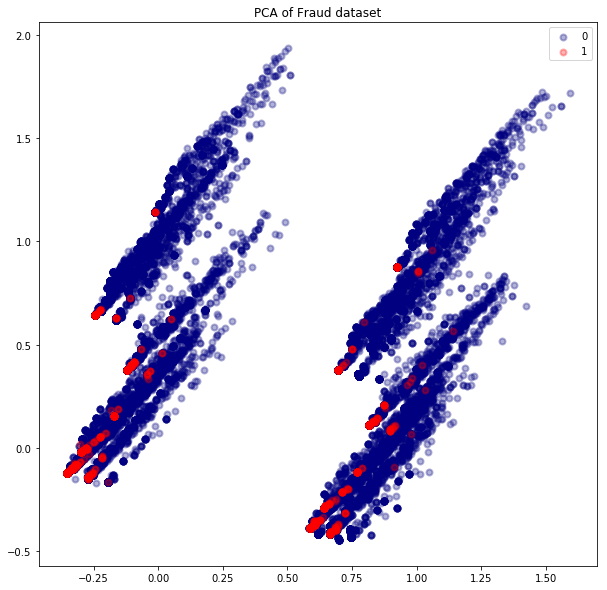

In [71]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_sc = scaler.fit_transform(X)

# scaler = Normalizer().fit(X)
# X = scaler.transform(X)

target_names = [0,1]

pca = PCA(n_components=2)
X_r = pca.fit(X_sc).transform(X_sc)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure(figsize=(10,10))
colors = ['navy', 'red']
lw = 2
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.3, lw=lw,label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Fraud dataset')

plt.show()

In [72]:
print ("Imbalance of the classes")
y.value_counts()

Imbalance of the classes


0    172450
1      1171
Name: fraud, dtype: int64

In [73]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def writeFeatureImportance(msg,model,auc,kappa):
    """
    This function ,based on the auc and kappa score writes the features importance to 
    featureImportance.txt.
    """
    if (auc>=0.71) and (kappa>=0.04):
        fh = open("featureImportance_all_vars.txt","a")
        if 'LR' in name:
            feature_list = ''.join(str(model.coef_.tolist()).replace('[','').replace(']',''))
        else :
            feature_list = ''.join(str(model.feature_importances_.tolist()).replace('[','').replace(']',''))
        fh.write(msg+","+feature_list+"\n") 
        fh.close()

#### Simple classifier with no sampling of data

================== Results for model :  LR =========================== 

Train ROC-AUC : 0.734723225366
Train Cohen-Kappa : 0.044582795547
Train Classification Report : 
              precision    recall  f1-score   support

          0       1.00      0.87      0.93    120710
          1       0.03      0.60      0.06       824

avg / total       0.99      0.86      0.92    121534

Test ROC_AUC : 0.739599070502
Test Cohen-Kappa : 0.0444592897852
Train Classification Report : 
              precision    recall  f1-score   support

          0       1.00      0.87      0.93     51740
          1       0.03      0.61      0.06       347

avg / total       0.99      0.86      0.92     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


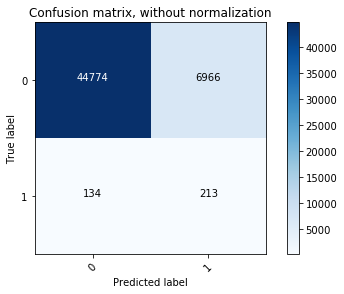

================== Results for model :  DT =========================== 

Train ROC-AUC : 0.753432814183
Train Cohen-Kappa : 0.0538781689137
Train Classification Report : 
              precision    recall  f1-score   support

          0       1.00      0.88      0.94    120710
          1       0.03      0.62      0.07       824

avg / total       0.99      0.88      0.93    121534

Test ROC_AUC : 0.738781136897
Test Cohen-Kappa : 0.0496919729263
Train Classification Report : 
              precision    recall  f1-score   support

          0       1.00      0.88      0.94     51740
          1       0.03      0.60      0.06       347

avg / total       0.99      0.88      0.93     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


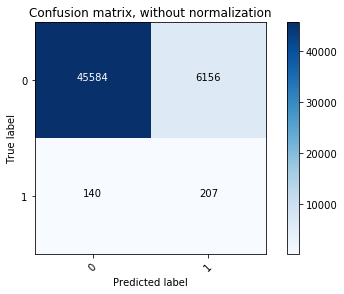

================== Results for model :  RF =========================== 

Train ROC-AUC : 0.749245332833
Train Cohen-Kappa : 0.0535678723047
Train Classification Report : 
              precision    recall  f1-score   support

          0       1.00      0.88      0.94    120710
          1       0.03      0.62      0.07       824

avg / total       0.99      0.88      0.93    121534

Test ROC_AUC : 0.734206083621
Test Cohen-Kappa : 0.0496794997942
Train Classification Report : 
              precision    recall  f1-score   support

          0       1.00      0.88      0.94     51740
          1       0.03      0.59      0.06       347

avg / total       0.99      0.88      0.93     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


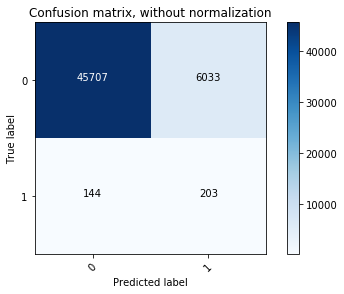

================== Results for model :  ET =========================== 

Train ROC-AUC : 0.753432814183
Train Cohen-Kappa : 0.0538781689137
Train Classification Report : 
              precision    recall  f1-score   support

          0       1.00      0.88      0.94    120710
          1       0.03      0.62      0.07       824

avg / total       0.99      0.88      0.93    121534

Test ROC_AUC : 0.739148357616
Test Cohen-Kappa : 0.0500516481981
Train Classification Report : 
              precision    recall  f1-score   support

          0       1.00      0.88      0.94     51740
          1       0.03      0.60      0.06       347

avg / total       0.99      0.88      0.93     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


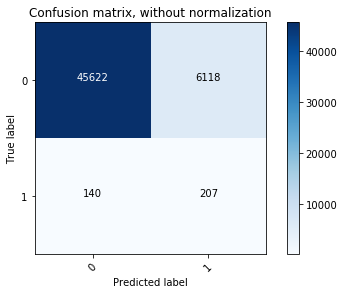

================== Results for model :  GBT =========================== 

Train ROC-AUC : 0.509048093682
Train Cohen-Kappa : 0.0347811337231
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.99      1.00      1.00    120710
          1       0.54      0.02      0.04       824

avg / total       0.99      0.99      0.99    121534

Test ROC_AUC : 0.507136965029
Test Cohen-Kappa : 0.0274220001653
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.99      1.00      1.00     51740
          1       0.42      0.01      0.03       347

avg / total       0.99      0.99      0.99     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


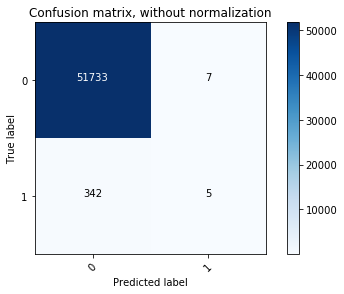

================== Results for model :  ABT =========================== 

Train ROC-AUC : 0.508138919966
Train Cohen-Kappa : 0.0288778779584
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.99      1.00      1.00    120710
          1       0.14      0.02      0.03       824

avg / total       0.99      0.99      0.99    121534

Test ROC_AUC : 0.506818062826
Test Cohen-Kappa : 0.0240174143422
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.99      1.00      1.00     51740
          1       0.11      0.01      0.03       347

avg / total       0.99      0.99      0.99     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


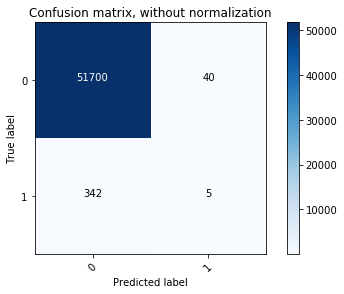

In [74]:
from sklearn.grid_search import GridSearchCV,RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,VotingClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.cross_validation import KFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

validation_size = 0.30
seed = 13


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=validation_size,random_state=seed)

scaler = MinMaxScaler(feature_range=(0,1))
X_train_sc = scaler.fit_transform(X_train)

models = []
models.append(( 'LR' , LogisticRegression(class_weight='balanced')))
models.append(( 'DT' , DecisionTreeClassifier(class_weight='balanced')))
models.append(( 'RF' , RandomForestClassifier(class_weight='balanced')))
models.append(( 'ET' , ExtraTreesClassifier(class_weight='balanced')))
models.append(( 'GBT' , GradientBoostingClassifier(max_features='auto')))
models.append(( 'ABT' , AdaBoostClassifier()))
#models.append(( 'KNN' , KNeighborsClassifier(n_neighbors=3)))
#models.append(( 'SVC' , SVC(kernel='rbf', probability=True)))
#models.append(( 'VC' , VotingClassifier(estimators=models[:-1],voting='soft')))


for name,model in models:
    print("================== Results for model : ",name+" =========================== \n")
    model.fit(X_train_sc, y_train)
    predictions_train = model.predict(X_train_sc)
    print("Train ROC-AUC :",roc_auc_score(y_train, predictions_train))
    print("Train Cohen-Kappa :",cohen_kappa_score(y_train, predictions_train))
    print("Train Classification Report : \n",classification_report(y_train,predictions_train))
    X_test_sc = scaler.transform(X_test)
    predictions = model.predict(X_test_sc)
    auc = roc_auc_score(y_test, predictions)
    print("Test ROC_AUC :",auc)
    kappa = cohen_kappa_score(y_test, predictions)
    print("Test Cohen-Kappa :",kappa)
    print("Train Classification Report : \n",classification_report(y_test, predictions))
    print("Test Confusion Matrix :\n ")
    cnf_matrix = confusion_matrix(y_test, predictions)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0,1],title='Confusion matrix, without normalization')
    plt.show()
    writeFeatureImportance("Class Weights ,"+name,model,auc,kappa)

#### Since the dataset is imbalaced one, lets try to the following techinques to see, if we can get higher precision and recall using the following :
#### 1) Ramdom Over Sampling
#### 2) Random Under Sampling


Distribution of class labels before resampling Counter({0: 120706, 1: 828})
Distribution of class labels after resampling Counter({0: 120706, 1: 120706})
================== Results for model :  LR =========================== 

Train ROC-AUC : 0.735485394264
Train Cohen-Kappa : 0.470970788527
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.69      0.86      0.76    120706
          1       0.81      0.61      0.70    120706

avg / total       0.75      0.74      0.73    241412

Test ROC-AUC : 0.740864365227
Test Cohen-Kappa : 0.0428336815128
Test Classification Report : 
              precision    recall  f1-score   support

          0       1.00      0.86      0.92     51744
          1       0.03      0.62      0.05       343

avg / total       0.99      0.86      0.92     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


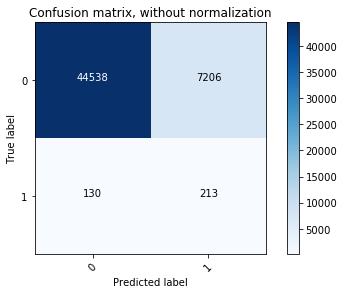

================== Results for model :  DT =========================== 

Train ROC-AUC : 0.753322121518
Train Cohen-Kappa : 0.506644243037
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.70      0.88      0.78    120706
          1       0.84      0.62      0.72    120706

avg / total       0.77      0.75      0.75    241412

Test ROC-AUC : 0.742756924198
Test Cohen-Kappa : 0.0503462905336
Test Classification Report : 
              precision    recall  f1-score   support

          0       1.00      0.88      0.94     51744
          1       0.03      0.60      0.06       343

avg / total       0.99      0.88      0.93     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


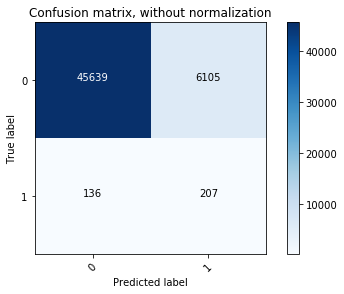

================== Results for model :  RF =========================== 

Train ROC-AUC : 0.75330969463
Train Cohen-Kappa : 0.50661938926
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.70      0.88      0.78    120706
          1       0.84      0.62      0.72    120706

avg / total       0.77      0.75      0.75    241412

Test ROC-AUC : 0.744349931531
Test Cohen-Kappa : 0.0507757886252
Test Classification Report : 
              precision    recall  f1-score   support

          0       1.00      0.88      0.94     51744
          1       0.03      0.61      0.06       343

avg / total       0.99      0.88      0.93     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


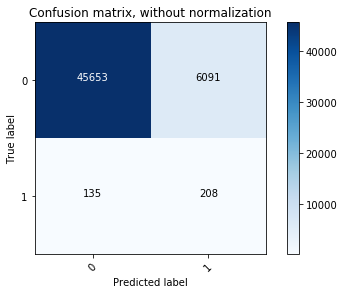

================== Results for model :  ET =========================== 

Train ROC-AUC : 0.753322121518
Train Cohen-Kappa : 0.506644243037
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.70      0.88      0.78    120706
          1       0.84      0.62      0.72    120706

avg / total       0.77      0.75      0.75    241412

Test ROC-AUC : 0.745884961127
Test Cohen-Kappa : 0.0511486353678
Test Classification Report : 
              precision    recall  f1-score   support

          0       1.00      0.88      0.94     51744
          1       0.03      0.61      0.06       343

avg / total       0.99      0.88      0.93     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


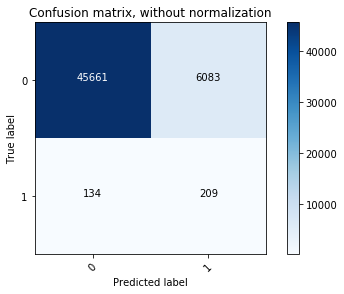

================== Results for model :  GBT =========================== 

Train ROC-AUC : 0.738517555051
Train Cohen-Kappa : 0.477035110102
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.68      0.89      0.77    120706
          1       0.84      0.59      0.69    120706

avg / total       0.76      0.74      0.73    241412

Test ROC-AUC : 0.736387655712
Test Cohen-Kappa : 0.0509534335017
Test Classification Report : 
              precision    recall  f1-score   support

          0       1.00      0.89      0.94     51744
          1       0.03      0.59      0.06       343

avg / total       0.99      0.88      0.93     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


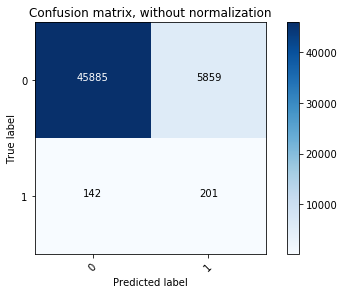

================== Results for model :  ABT =========================== 

Train ROC-AUC : 0.726214935463
Train Cohen-Kappa : 0.452429870926
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.72      0.74      0.73    120706
          1       0.73      0.71      0.72    120706

avg / total       0.73      0.73      0.73    241412

Test ROC-AUC : 0.742083278116
Test Cohen-Kappa : 0.0241122669813
Test Classification Report : 
              precision    recall  f1-score   support

          0       1.00      0.74      0.85     51744
          1       0.02      0.74      0.04       343

avg / total       0.99      0.74      0.85     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


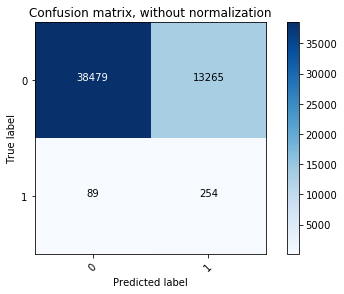

In [75]:
#Random Oversampling
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7)
y_train, y_test = np.asarray(y_train),np.asarray(y_test)
os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_sample(X_train, y_train)

print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))


models = []
models.append(( 'LR' , LogisticRegression()))
models.append(( 'DT' , DecisionTreeClassifier()))
models.append(( 'RF' , RandomForestClassifier()))
models.append(( 'ET' , ExtraTreesClassifier()))
models.append(( 'GBT' , GradientBoostingClassifier()))
models.append(( 'ABT' , AdaBoostClassifier()))
#models.append(( 'KNN' , KNeighborsClassifier(n_neighbors=3)))
#models.append(( 'SVC' , SVC(kernel='rbf', probability=True)))
#models.append(( 'VC' , VotingClassifier(estimators=models[:-1],voting='soft')))

for name,model in models:
    print("================== Results for model : ",name+" =========================== \n")
    model.fit(X_train_res, y_train_res)
    predictions_train = model.predict(X_train_res)
    print("Train ROC-AUC :",roc_auc_score(y_train_res, predictions_train))
    print("Train Cohen-Kappa :",cohen_kappa_score(y_train_res, predictions_train))
    print("Train Classification Report : \n",classification_report(y_train_res,predictions_train))
    predictions = model.predict(X_test)
    auc = roc_auc_score(y_test, predictions)
    print("Test ROC-AUC :",auc)
    kappa = cohen_kappa_score(y_test, predictions)
    print("Test Cohen-Kappa :",kappa)
    print("Test Classification Report : \n",classification_report(y_test, predictions))
    print("Test Confusion Matrix :\n ")
    cnf_matrix = confusion_matrix(y_test,predictions)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0,1],title='Confusion matrix, without normalization')
    plt.show()
    writeFeatureImportance("Random Over Sampling ,"+name,model,auc,kappa)

#### Random Under Sampling

Distribution of class labels before resampling Counter({0: 120711, 1: 823})
Distribution of class labels after resampling Counter({0: 823, 1: 823})
================== Results for model :  LR =========================== 

Train ROC-AUC : 0.730862697448
Train Cohen-Kappa : 0.461725394897
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.72      0.75      0.74       823
          1       0.74      0.71      0.73       823

avg / total       0.73      0.73      0.73      1646

Test ROC-AUC : 0.725724030851
Test Cohen-Kappa : 0.0224117588624
Test Classification Report : 
              precision    recall  f1-score   support

          0       1.00      0.74      0.85     51739
          1       0.02      0.71      0.04       348

avg / total       0.99      0.74      0.84     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


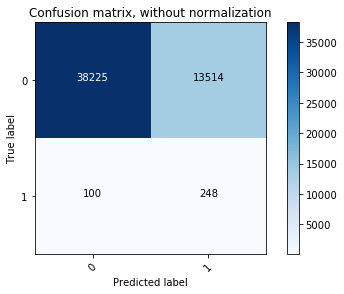

================== Results for model :  DT =========================== 

Train ROC-AUC : 0.759416767922
Train Cohen-Kappa : 0.518833535844
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.70      0.91      0.79       823
          1       0.87      0.61      0.72       823

avg / total       0.78      0.76      0.75      1646

Test ROC-AUC : 0.721803268528
Test Cohen-Kappa : 0.0391748113443
Test Classification Report : 
              precision    recall  f1-score   support

          0       1.00      0.86      0.92     51739
          1       0.03      0.59      0.05       348

avg / total       0.99      0.86      0.92     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


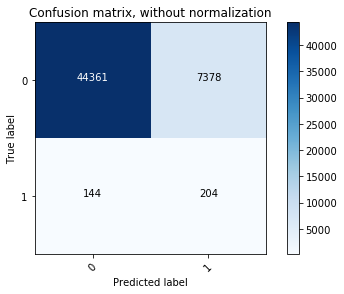

================== Results for model :  RF =========================== 

Train ROC-AUC : 0.758809234508
Train Cohen-Kappa : 0.517618469016
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.70      0.91      0.79       823
          1       0.87      0.61      0.72       823

avg / total       0.78      0.76      0.75      1646

Test ROC-AUC : 0.724628262368
Test Cohen-Kappa : 0.0420141415781
Test Classification Report : 
              precision    recall  f1-score   support

          0       1.00      0.87      0.93     51739
          1       0.03      0.58      0.05       348

avg / total       0.99      0.86      0.92     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


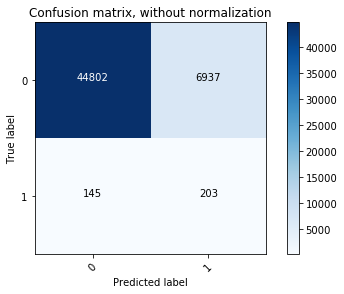

================== Results for model :  ET =========================== 

Train ROC-AUC : 0.759416767922
Train Cohen-Kappa : 0.518833535844
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.70      0.91      0.79       823
          1       0.87      0.61      0.72       823

avg / total       0.78      0.76      0.75      1646

Test ROC-AUC : 0.729173678541
Test Cohen-Kappa : 0.043865413668
Test Classification Report : 
              precision    recall  f1-score   support

          0       1.00      0.87      0.93     51739
          1       0.03      0.59      0.06       348

avg / total       0.99      0.87      0.92     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


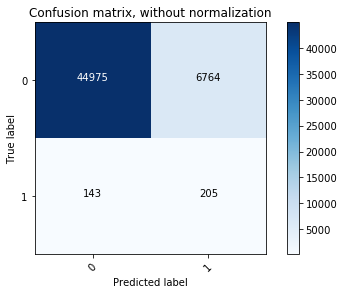

================== Results for model :  GBT =========================== 

Train ROC-AUC : 0.746658566221
Train Cohen-Kappa : 0.493317132442
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.74      0.77      0.75       823
          1       0.76      0.73      0.74       823

avg / total       0.75      0.75      0.75      1646

Test ROC-AUC : 0.72444187148
Test Cohen-Kappa : 0.0223113275595
Test Classification Report : 
              precision    recall  f1-score   support

          0       1.00      0.74      0.85     51739
          1       0.02      0.71      0.04       348

avg / total       0.99      0.74      0.84     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


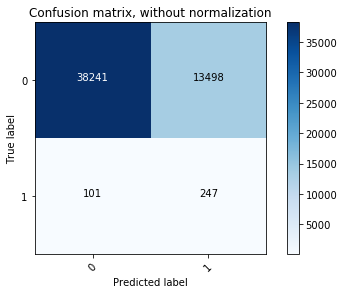

================== Results for model :  ABT =========================== 

Train ROC-AUC : 0.732685297691
Train Cohen-Kappa : 0.465370595383
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.72      0.75      0.74       823
          1       0.74      0.71      0.73       823

avg / total       0.73      0.73      0.73      1646

Test ROC-AUC : 0.727031793976
Test Cohen-Kappa : 0.0230061374014
Test Classification Report : 
              precision    recall  f1-score   support

          0       1.00      0.74      0.85     51739
          1       0.02      0.71      0.04       348

avg / total       0.99      0.74      0.85     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


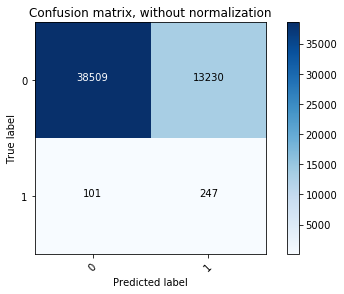

In [76]:
#Random Under Sampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter


X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7)
y_train, y_test = np.asarray(y_train),np.asarray(y_test)
us =  RandomUnderSampler()
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))


models = []
models.append(( 'LR' , LogisticRegression()))
models.append(( 'DT' , DecisionTreeClassifier()))
models.append(( 'RF' , RandomForestClassifier()))
models.append(( 'ET' , ExtraTreesClassifier()))
models.append(( 'GBT' , GradientBoostingClassifier()))
models.append(( 'ABT' , AdaBoostClassifier()))
#models.append(( 'KNN' , KNeighborsClassifier(n_neighbors=3)))
#models.append(( 'SVC' , SVC(kernel='rbf', probability=True)))
#models.append(( 'VC' , VotingClassifier(estimators=models[:-1],voting='soft')))

for name,model in models:
    print("================== Results for model : ",name+" =========================== \n")
    model.fit(X_train_res, y_train_res)
    predictions_train = model.predict(X_train_res)
    print("Train ROC-AUC :",roc_auc_score(y_train_res, predictions_train))
    print("Train Cohen-Kappa :",cohen_kappa_score(y_train_res, predictions_train))
    print("Train Classification Report : \n",classification_report(y_train_res,predictions_train))
    predictions = model.predict(X_test)
    auc = roc_auc_score(y_test, predictions)
    print("Test ROC-AUC :",auc)
    kappa = cohen_kappa_score(y_test, predictions)
    print("Test Cohen-Kappa :",kappa)
    print("Test Classification Report : \n",classification_report(y_test, predictions))
    print("Test Confusion Matrix :\n ")
    cnf_matrix = confusion_matrix(y_test,predictions)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0,1],title='Confusion matrix, without normalization')
    plt.show()
    writeFeatureImportance("Random Under Sampler ,"+name,model,auc,kappa)

#### SMOTE - Takes awfully long time to train, hence skipping .

In [77]:
# # Majority class : 0  /  Minority class : L 
# # Our goal is to maximise precision on the majority class and maximise recall on the minority class.

# from imblearn.combine import SMOTETomek

# X_smt = X[ X.columns.intersection(f_classif_list)]
# y_smt = y

# print("Smote data shape",X_smt.shape)

# print("Smote data shape",y_smt.shape)


# X_train, X_test, y_train, y_test = train_test_split(X_r, y_smt, train_size=0.7)

# y_train, y_test = np.asarray(y_train), np.asarray(y_test)

# os_us = SMOTETomek(ratio=0.5,k=5)
# X_train_res, y_train_res = os_us.fit_sample(X_train, y_train)

# print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
# print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))

# #lr = LogisticRegression(n_jobs=10) 
# lr = ExtraTreesClassifier(n_estimators=100)
# # #param_grid = { 'C': np.arange(1,11,1)}
# # #CV_lr = RandomizedSearchCV(estimator=lr,param_distributions=param_grid,cv=10,scoring='f1_weighted',random_state=seed)
# # CV_lr = lr
# # CV_lr.fit(X_train_sc, y_train)
# # #print (CV_lr.best_params_)
# # #lr = CV_lr.best_estimator_

# lr.fit(X_train_res, y_train_res)

# predictions_train = lr.predict(X_train_res)
# print("Train Classification Report : \n",classification_report(y_train_res,predictions_train))

# X_test_sc = scaler.transform(X_test)
# predictions = lr.predict(X_test_sc)

# print("Test Classification Report : \n",classification_report(y_test, predictions))

# print("Test Confusion Matrix :\n ")
# cnf_matrix = confusion_matrix(y_test, predictions)
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=[0,1],title='Confusion matrix, without normalization')

#### Near Miss is another under sampling method technique which gives a better seperation of class after sampling

/Users/anilkumarpanda/SoftwareInstalls/anaconda/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'size_ngh' is deprecated from 0.2 and will be removed in 0.4. Use 'n_neighbors' instead.
  category=DeprecationWarning)


Distribution of class labels before resampling Counter({0: 120687, 1: 847})
Distribution of class labels after resampling Counter({0: 1694, 1: 847})
================== Results for model :  LR =========================== 

Train ROC-AUC : 0.935950413223
Train Cohen-Kappa : 0.898691816246
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.94      1.00      0.97      1694
          1       0.99      0.87      0.93       847

avg / total       0.96      0.96      0.96      2541

Test ROC-AUC : 0.509854714138
Test Cohen-Kappa : 0.000288928811903
Test Classification Report : 
              precision    recall  f1-score   support

          0       0.99      0.15      0.26     51763
          1       0.01      0.87      0.01       324

avg / total       0.99      0.16      0.26     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


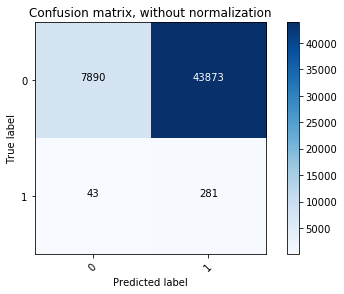

================== Results for model :  DT =========================== 

Train ROC-AUC : 0.946280991736
Train Cohen-Kappa : 0.917197452229
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.95      1.00      0.97      1694
          1       1.00      0.89      0.94       847

avg / total       0.97      0.96      0.96      2541

Test ROC-AUC : 0.507261878271
Test Cohen-Kappa : 0.00020716738714
Test Classification Report : 
              precision    recall  f1-score   support

          0       0.99      0.13      0.23     51763
          1       0.01      0.89      0.01       324

avg / total       0.99      0.13      0.23     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


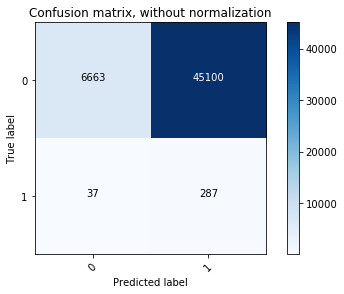

================== Results for model :  RF =========================== 

Train ROC-AUC : 0.946280991736
Train Cohen-Kappa : 0.917197452229
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.95      1.00      0.97      1694
          1       1.00      0.89      0.94       847

avg / total       0.97      0.96      0.96      2541

Test ROC-AUC : 0.5067692484
Test Cohen-Kappa : 0.000192898408111
Test Classification Report : 
              precision    recall  f1-score   support

          0       0.99      0.13      0.23     51763
          1       0.01      0.89      0.01       324

avg / total       0.99      0.13      0.23     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


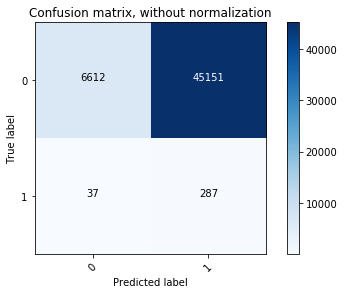

================== Results for model :  ET =========================== 

Train ROC-AUC : 0.946280991736
Train Cohen-Kappa : 0.917197452229
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.95      1.00      0.97      1694
          1       1.00      0.89      0.94       847

avg / total       0.97      0.96      0.96      2541

Test ROC-AUC : 0.503272542259
Test Cohen-Kappa : 9.25234446741e-05
Test Classification Report : 
              precision    recall  f1-score   support

          0       0.99      0.12      0.22     51763
          1       0.01      0.89      0.01       324

avg / total       0.99      0.13      0.21     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


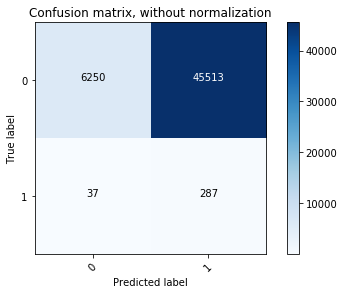

================== Results for model :  GBT =========================== 

Train ROC-AUC : 0.946280991736
Train Cohen-Kappa : 0.917197452229
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.95      1.00      0.97      1694
          1       1.00      0.89      0.94       847

avg / total       0.97      0.96      0.96      2541

Test ROC-AUC : 0.50827382064
Test Cohen-Kappa : 0.000235747366537
Test Classification Report : 
              precision    recall  f1-score   support

          0       0.99      0.13      0.23     51763
          1       0.01      0.89      0.01       324

avg / total       0.99      0.13      0.22     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


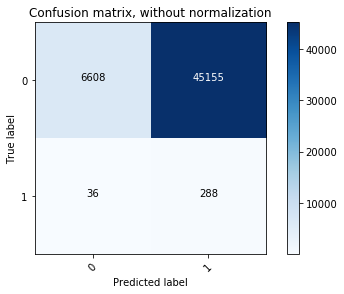

================== Results for model :  ABT =========================== 

Train ROC-AUC : 0.941853600945
Train Cohen-Kappa : 0.908098271156
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.95      1.00      0.97      1694
          1       0.99      0.89      0.94       847

avg / total       0.96      0.96      0.96      2541

Test ROC-AUC : 0.503506663681
Test Cohen-Kappa : 9.95418978563e-05
Test Classification Report : 
              precision    recall  f1-score   support

          0       0.99      0.12      0.22     51763
          1       0.01      0.88      0.01       324

avg / total       0.99      0.13      0.22     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


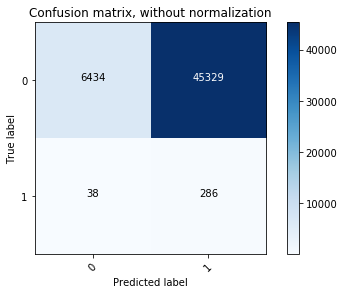

In [78]:
from imblearn.under_sampling import NearMiss
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
us = NearMiss(ratio=0.5,size_ngh=3, version=2)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))

models = []
models.append(( 'LR' , LogisticRegression()))
models.append(( 'DT' , DecisionTreeClassifier()))
models.append(( 'RF' , RandomForestClassifier()))
models.append(( 'ET' , ExtraTreesClassifier()))
models.append(( 'GBT' , GradientBoostingClassifier()))
models.append(( 'ABT' , AdaBoostClassifier()))
#models.append(( 'KNN' , KNeighborsClassifier(n_neighbors=3)))
#models.append(( 'SVC' , SVC(kernel='rbf', probability=True)))
#models.append(( 'VC' , VotingClassifier(estimators=models[:-1],voting='soft')))

for name,model in models:
    print("================== Results for model : ",name+" =========================== \n")
    model.fit(X_train_res, y_train_res)
    predictions_train = model.predict(X_train_res)
    print("Train ROC-AUC :",roc_auc_score(y_train_res, predictions_train))
    print("Train Cohen-Kappa :",cohen_kappa_score(y_train_res, predictions_train))
    print("Train Classification Report : \n",classification_report(y_train_res,predictions_train))
    predictions = model.predict(X_test)
    auc = roc_auc_score(y_test, predictions)
    print("Test ROC-AUC :",auc)
    kappa = cohen_kappa_score(y_test, predictions)
    print("Test Cohen-Kappa :",kappa)
    print("Test Classification Report : \n",classification_report(y_test, predictions))
    print("Test Confusion Matrix :\n ")
    cnf_matrix = confusion_matrix(y_test,predictions)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0,1],title='Confusion matrix, without normalization')
    plt.show()
    writeFeatureImportance("Near Miss ,"+name,model,auc,kappa)

================== Results for model :  LR =========================== 

Test ROC-AUC : 0.256914187456
Test Cohen-Kappa : -0.00807431579553
             precision    recall  f1-score   support

          0       0.97      0.14      0.24     51715
          1       0.00      0.38      0.01       372

avg / total       0.96      0.14      0.24     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


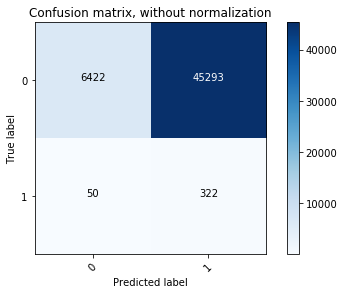

================== Results for model :  DT =========================== 

Test ROC-AUC : 0.254652333561
Test Cohen-Kappa : -0.00803301549749
             precision    recall  f1-score   support

          0       0.97      0.12      0.22     51715
          1       0.00      0.38      0.01       372

avg / total       0.96      0.13      0.22     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


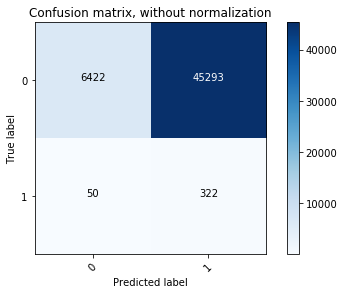

================== Results for model :  RF =========================== 

Test ROC-AUC : 0.252563600752
Test Cohen-Kappa : -0.00811274587877
             precision    recall  f1-score   support

          0       0.97      0.13      0.22     51715
          1       0.00      0.38      0.01       372

avg / total       0.96      0.13      0.22     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


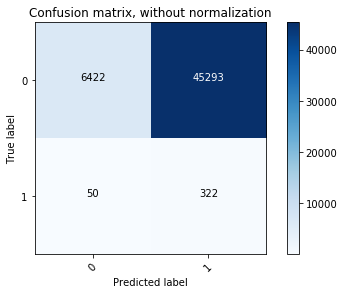

================== Results for model :  ET =========================== 

Test ROC-AUC : 0.254139727768
Test Cohen-Kappa : -0.00806512702764
             precision    recall  f1-score   support

          0       0.97      0.13      0.22     51715
          1       0.00      0.38      0.01       372

avg / total       0.96      0.13      0.22     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


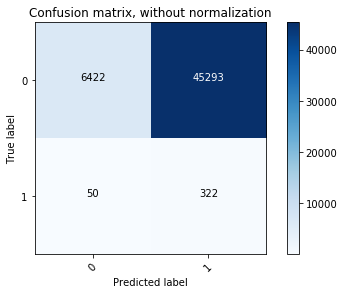

================== Results for model :  GBT =========================== 

Test ROC-AUC : 0.255445868017
Test Cohen-Kappa : -0.00792428817838
             precision    recall  f1-score   support

          0       0.96      0.12      0.21     51715
          1       0.00      0.40      0.01       372

avg / total       0.96      0.12      0.21     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


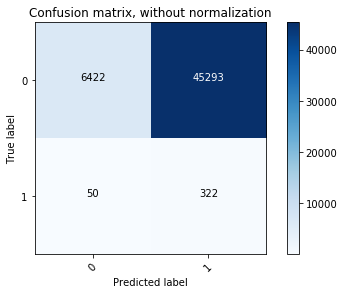

================== Results for model :  ABT =========================== 

Test ROC-AUC : 0.419576483602
Test Cohen-Kappa : -0.00232601341174
             precision    recall  f1-score   support

          0       0.90      0.01      0.02     51715
          1       0.01      0.83      0.01       372

avg / total       0.89      0.02      0.02     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


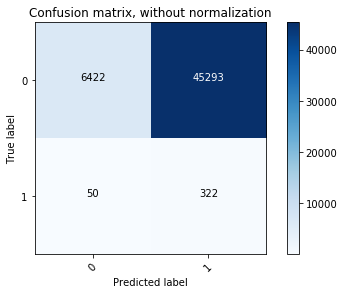

In [79]:
from imblearn.ensemble import EasyEnsemble
import pandas as pd
import numpy as np
from sklearn.cross_validation import KFold, train_test_split
from imblearn.ensemble import EasyEnsemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from collections import Counter

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
y_train, y_test = np.asarray(y_train), np.asarray(y_test)
ens = EasyEnsemble()
X_train_res, y_train_res = ens.fit_sample(X_train, y_train)
y_pred_proba = np.zeros(len(y_test))

models = []
models.append(( 'LR' , LogisticRegression()))
models.append(( 'DT' , DecisionTreeClassifier()))
models.append(( 'RF' , RandomForestClassifier()))
models.append(( 'ET' , ExtraTreesClassifier()))
models.append(( 'GBT' , GradientBoostingClassifier()))
models.append(( 'ABT' , AdaBoostClassifier()))
#models.append(( 'KNN' , KNeighborsClassifier(n_neighbors=3)))
#models.append(( 'SVC' , SVC(kernel='rbf', probability=True)))
#models.append(( 'VC' , VotingClassifier(estimators=models[:-1],voting='soft')))

for name,model in models:
    print("================== Results for model : ",name+" =========================== \n")
    for idx in range(len(y_train_res)):
        clf_base = model
        #grid = {'n_estimators': [50]}
        cv = KFold(X_train_res.shape[0], n_folds=5, shuffle=True, random_state=0)
        #clf = GridSearchCV(clf_base, grid, cv=cv, scoring='f1_weighted')
        clf_base.fit(X_train_res[idx], y_train_res[idx])
        y_pred_proba += list(zip(*clf_base.predict_proba(X_test)))[0]
    y_pred_proba = y_pred_proba/len(y_train_res)
    y_pred = (y_pred_proba > 0.5).astype(int)
    auc = roc_auc_score(y_test, y_pred)
    print("Test ROC-AUC :",auc)
    kappa = cohen_kappa_score(y_test,y_pred)
    print("Test Cohen-Kappa :",kappa)
    print (classification_report(y_test, y_pred))
    print("Test Confusion Matrix :\n ")
    cnf_matrix = confusion_matrix(y_test, predictions)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0,1],title='Confusion matrix, without normalization')
    plt.show()
    writeFeatureImportance("Easy Ensemble,"+name,model,auc,kappa)

#### SMOTE with ENN , takes ages to train, hence skipping

In [80]:
from imblearn.combine import SMOTEENN
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

# y_train, y_test = np.asarray(y_train), np.asarray(y_test)

# sm = SMOTEENN()
# X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

# print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
# print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))

# #lr = LogisticRegression(n_jobs=10) 
# lr = ExtraTreesClassifier(n_estimators=100)
# # #param_grid = { 'C': np.arange(1,11,1)}
# # #CV_lr = RandomizedSearchCV(estimator=lr,param_distributions=param_grid,cv=10,scoring='f1_weighted',random_state=seed)
# # CV_lr = lr
# # CV_lr.fit(X_train_sc, y_train)
# # #print (CV_lr.best_params_)
# # #lr = CV_lr.best_estimator_

# lr.fit(X_train_res, y_train_res)

# predictions_train = lr.predict(X_train_res)
# print("Train Classification Report : \n",classification_report(y_train_res,predictions_train))

# X_test_sc = scaler.transform(X_test)
# predictions = lr.predict(X_test_sc)

# print("Test Classification Report : \n",classification_report(y_test, predictions))

# print("Test Confusion Matrix :\n ")
# cnf_matrix = confusion_matrix(y_test, predictions)
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=[0,1],title='Confusion matrix, without normalization')

In [81]:
#from imblearn.under_sampling import RepeatedEditedNearestNeighbours
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
# renn = RepeatedEditedNearestNeighbours(random_state=0)
# X_train_res, y_train_res = renn.fit_sample(X_train, y_train)
# # print(sorted(Counter(y_resampled).items()))
# # X_train_res, y_train_res = us.fit_sample(X_train, y_train)
# print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
# print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))
# #lr = LogisticRegression(n_jobs=10) 
# lr = ExtraTreesClassifier(n_estimators=100)

# # #param_grid = { 'C': np.arange(1,11,1)}
# # #CV_lr = RandomizedSearchCV(estimator=lr,param_distributions=param_grid,cv=10,scoring='f1_weighted',random_state=seed)
# # CV_lr = lr
# # CV_lr.fit(X_train_sc, y_train)
# # #print (CV_lr.best_params_)
# # #lr = CV_lr.best_estimator_
# lr.fit(X_train_res, y_train_res)
# predictions_train = lr.predict(X_train_res)
# print("Train Classification Report : \n",classification_report(y_train_res,predictions_train))
# X_test_sc = scaler.transform(X_test)
# predictions = lr.predict(X_test_sc)
# print("Test Classification Report : \n",classification_report(y_test, predictions))
# print("Test Confusion Matrix :\n ")
# cnf_matrix = confusion_matrix(y_test, predictions)
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=[0,1],title='Confusion matrix, without normalization')

#### Of all the sampling techniques used, Balanced Bagging classifer showed the most promise .

Results of Balanced Bagging Classifier using Base Estimator :LR

Class distribution of the training set: Counter({0: 129331, 1: 884})
Train ROC-AUC : 0.735699182507
Train Cohen-Kappa : 0.0397838854818
Class distribution of the test set: Counter({0: 43119, 1: 287})
Classification results using a bagging classifier on balanced data
Test ROC-AUC : 0.727673104324
Test Cohen-Kappa : 0.0369351113353
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.85      0.61      0.92      0.16      0.03     43119
          1       0.03      0.61      0.85      0.05      0.16      0.02       287

avg / total       0.99      0.84      0.61      0.91      0.16      0.03     43406

Confusion matrix, without normalization


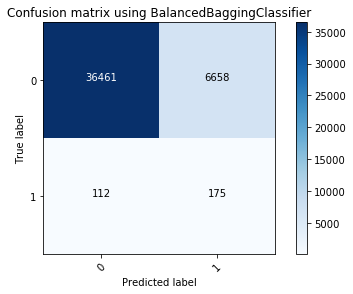

Results of Balanced Bagging Classifier using Base Estimator :DT

Class distribution of the training set: Counter({0: 129331, 1: 884})
Train ROC-AUC : 0.746258609088
Train Cohen-Kappa : 0.0438772851191
Class distribution of the test set: Counter({0: 43119, 1: 287})
Classification results using a bagging classifier on balanced data
Test ROC-AUC : 0.728166148734
Test Cohen-Kappa : 0.0388989294763
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.85      0.60      0.92      0.16      0.03     43119
          1       0.03      0.60      0.85      0.05      0.16      0.02       287

avg / total       0.99      0.85      0.60      0.91      0.16      0.03     43406

Confusion matrix, without normalization


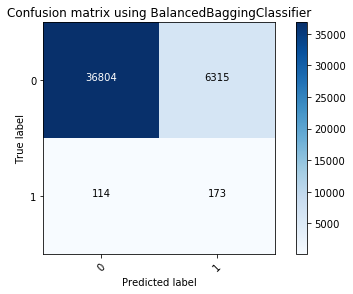

Results of Balanced Bagging Classifier using Base Estimator :RF

Class distribution of the training set: Counter({0: 129331, 1: 884})
Train ROC-AUC : 0.746409385004
Train Cohen-Kappa : 0.0439900067787
Class distribution of the test set: Counter({0: 43119, 1: 287})
Classification results using a bagging classifier on balanced data
Test ROC-AUC : 0.730348950029
Test Cohen-Kappa : 0.0394865885427
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.85      0.61      0.92      0.16      0.03     43119
          1       0.03      0.61      0.85      0.05      0.16      0.02       287

avg / total       0.99      0.85      0.61      0.91      0.16      0.03     43406

Confusion matrix, without normalization


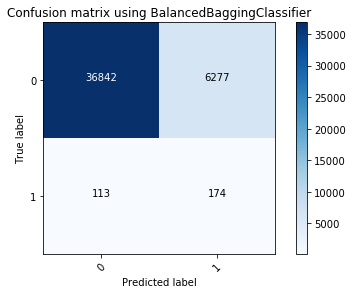

Results of Balanced Bagging Classifier using Base Estimator :ET

Class distribution of the training set: Counter({0: 129331, 1: 884})
Train ROC-AUC : 0.748616899057
Train Cohen-Kappa : 0.0456923348283
Class distribution of the test set: Counter({0: 43119, 1: 287})
Classification results using a bagging classifier on balanced data
Test ROC-AUC : 0.730902761364
Test Cohen-Kappa : 0.0407853912994
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.86      0.60      0.92      0.17      0.03     43119
          1       0.03      0.60      0.86      0.05      0.17      0.02       287

avg / total       0.99      0.86      0.60      0.92      0.17      0.03     43406

Confusion matrix, without normalization


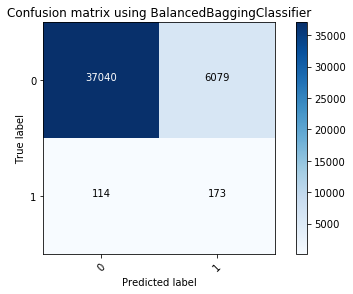

Results of Balanced Bagging Classifier using Base Estimator :GBT

Class distribution of the training set: Counter({0: 129331, 1: 884})
Train ROC-AUC : 0.741400437287
Train Cohen-Kappa : 0.0441404727797
Class distribution of the test set: Counter({0: 43119, 1: 287})
Classification results using a bagging classifier on balanced data
Test ROC-AUC : 0.723771778822
Test Cohen-Kappa : 0.0394654952968
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.86      0.59      0.92      0.16      0.03     43119
          1       0.03      0.59      0.86      0.05      0.16      0.02       287

avg / total       0.99      0.86      0.59      0.92      0.16      0.03     43406

Confusion matrix, without normalization


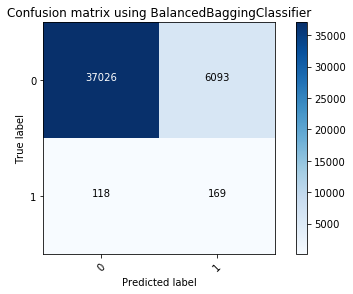

Results of Balanced Bagging Classifier using Base Estimator :ABT

Class distribution of the training set: Counter({0: 129331, 1: 884})
Train ROC-AUC : 0.73756181349
Train Cohen-Kappa : 0.0422431662743
Class distribution of the test set: Counter({0: 43119, 1: 287})
Classification results using a bagging classifier on balanced data
Test ROC-AUC : 0.726447180087
Test Cohen-Kappa : 0.0386229636446
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.85      0.60      0.92      0.16      0.03     43119
          1       0.03      0.60      0.85      0.05      0.16      0.02       287

avg / total       0.99      0.85      0.60      0.91      0.16      0.03     43406

Confusion matrix, without normalization


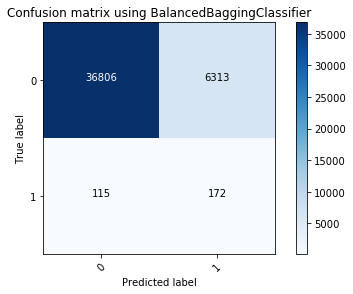

In [82]:
from collections import Counter
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier,AdaBoostClassifier,RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from imblearn.datasets import make_imbalance
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.metrics import classification_report_imbalanced

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

models = []
models.append(( 'LR' , LogisticRegression(class_weight='balanced')))
models.append(( 'DT' , DecisionTreeClassifier(class_weight='balanced')))
models.append(( 'RF' , RandomForestClassifier(class_weight='balanced')))
models.append(( 'ET' , ExtraTreesClassifier(class_weight='balanced')))
models.append(( 'GBT' , GradientBoostingClassifier(max_features='auto')))
models.append(( 'ABT' , AdaBoostClassifier()))

for name,model in models:
    print('Results of Balanced Bagging Classifier using Base Estimator :'+name+"\n")
    balanced_bagging = BalancedBaggingClassifier(random_state=0,n_estimators=250,base_estimator=model)
    print('Class distribution of the training set: {}'.format(Counter(y_train)))
    balanced_bagging.fit(X_train, y_train)
    predictions_train = balanced_bagging.predict(X_train)
    print("Train ROC-AUC :",roc_auc_score(y_train, predictions_train))
    print("Train Cohen-Kappa :",cohen_kappa_score(y_train,predictions_train))
    print('Class distribution of the test set: {}'.format(Counter(y_test)))
    print('Classification results using a bagging classifier on balanced data')
    y_pred_balanced_bagging = balanced_bagging.predict(X_test)
    auc = roc_auc_score(y_test, y_pred_balanced_bagging)
    print("Test ROC-AUC :",auc)
    kappa = cohen_kappa_score(y_test, y_pred_balanced_bagging)
    print("Test Cohen-Kappa :",kappa)
    print(classification_report_imbalanced(y_test, y_pred_balanced_bagging))
    cm_balanced_bagging = confusion_matrix(y_test, y_pred_balanced_bagging)
    plt.figure()
    plot_confusion_matrix(cm_balanced_bagging,classes=[0,1],title='Confusion matrix using BalancedBaggingClassifier')
    plt.show()
    #writeFeatureImportance("Balanced Bagging Classifier,"+name,balanced_bagging.base_estimator,auc,kappa)

Distribution of class labels before resampling Counter({0: 120730, 1: 804})
Distribution of class labels after resampling Counter({1: 120907, 0: 120730})
================== Results for model :  LR =========================== 

Train ROC-AUC : 0.675404593611
Train Cohen-Kappa : 0.350716929445
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.63      0.85      0.72    120730
          1       0.77      0.50      0.60    120907

avg / total       0.70      0.68      0.66    241637

Test ROC-AUC : 0.717472251549
Test Cohen-Kappa : 0.0396596860927
Test Classification Report : 
              precision    recall  f1-score   support

          0       1.00      0.85      0.92     51720
          1       0.03      0.58      0.05       367

avg / total       0.99      0.85      0.91     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


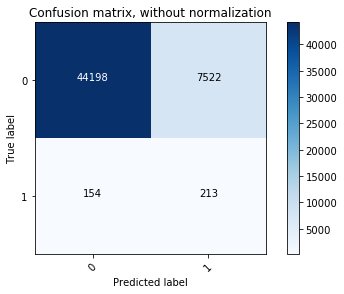

================== Results for model :  DT =========================== 

Train ROC-AUC : 0.946247894131
Train Cohen-Kappa : 0.892425547336
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.90      1.00      0.95    120730
          1       1.00      0.89      0.94    120907

avg / total       0.95      0.95      0.95    241637

Test ROC-AUC : 0.51879321372
Test Cohen-Kappa : 0.0669136547236
Test Classification Report : 
              precision    recall  f1-score   support

          0       0.99      1.00      1.00     51720
          1       0.33      0.04      0.07       367

avg / total       0.99      0.99      0.99     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


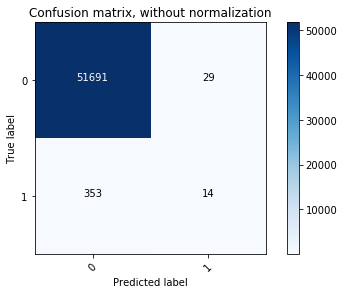

================== Results for model :  RF =========================== 

Train ROC-AUC : 0.946243673841
Train Cohen-Kappa : 0.892417253496
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.90      1.00      0.95    120730
          1       1.00      0.89      0.94    120907

avg / total       0.95      0.95      0.95    241637

Test ROC-AUC : 0.527035272722
Test Cohen-Kappa : 0.0964920622646
Test Classification Report : 
              precision    recall  f1-score   support

          0       0.99      1.00      1.00     51720
          1       0.48      0.05      0.10       367

avg / total       0.99      0.99      0.99     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


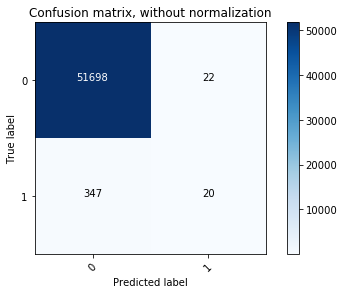

================== Results for model :  ET =========================== 

Train ROC-AUC : 0.946247894131
Train Cohen-Kappa : 0.892425547336
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.90      1.00      0.95    120730
          1       1.00      0.89      0.94    120907

avg / total       0.95      0.95      0.95    241637

Test ROC-AUC : 0.518899555561
Test Cohen-Kappa : 0.0691233897219
Test Classification Report : 
              precision    recall  f1-score   support

          0       0.99      1.00      1.00     51720
          1       0.44      0.04      0.07       367

avg / total       0.99      0.99      0.99     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


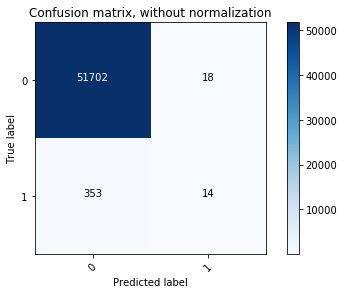

================== Results for model :  GBT =========================== 

Train ROC-AUC : 0.941368104433
Train Cohen-Kappa : 0.882660432541
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.89      1.00      0.94    120730
          1       1.00      0.88      0.94    120907

avg / total       0.95      0.94      0.94    241637

Test ROC-AUC : 0.49997099768
Test Cohen-Kappa : -0.00011427095855
Test Classification Report : 
              precision    recall  f1-score   support

          0       0.99      1.00      1.00     51720
          1       0.00      0.00      0.00       367

avg / total       0.99      0.99      0.99     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


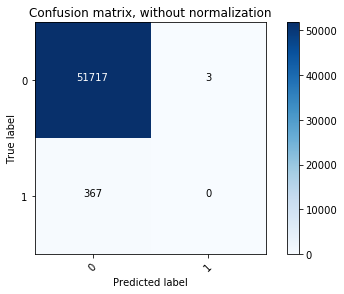

================== Results for model :  ABT =========================== 

Train ROC-AUC : 0.938414870621
Train Cohen-Kappa : 0.876758899505
Train Classification Report : 
              precision    recall  f1-score   support

          0       0.89      0.99      0.94    120730
          1       0.99      0.88      0.93    120907

avg / total       0.94      0.94      0.94    241637

Test ROC-AUC : 0.536580302446
Test Cohen-Kappa : 0.0767965823428
Test Classification Report : 
              precision    recall  f1-score   support

          0       0.99      0.99      0.99     51720
          1       0.09      0.08      0.08       367

avg / total       0.99      0.99      0.99     52087

Test Confusion Matrix :
 
Confusion matrix, without normalization


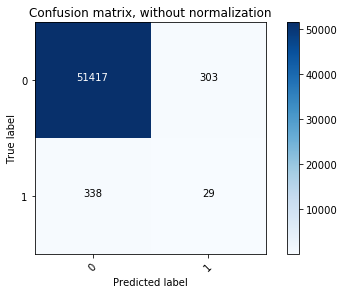

In [83]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import ADASYN 

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
ada = ADASYN(random_state=42)
X_res, y_res = ada.fit_sample(X_train, y_train)
X_train_res, y_train_res = ada.fit_sample(X_train, y_train)

print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))

models = []
models.append(( 'LR' , LogisticRegression()))
models.append(( 'DT' , DecisionTreeClassifier()))
models.append(( 'RF' , RandomForestClassifier()))
models.append(( 'ET' , ExtraTreesClassifier()))
models.append(( 'GBT' , GradientBoostingClassifier()))
models.append(( 'ABT' , AdaBoostClassifier()))
#models.append(( 'VC' , VotingClassifier(estimators=models[:-1],voting='hard',weights=[5,3,3,3,1])))

for name,model in models:
    print("================== Results for model : ",name+" =========================== \n")
    model.fit(X_train_res, y_train_res)
    predictions_train = model.predict(X_train_res)
    print("Train ROC-AUC :",roc_auc_score(y_train_res, predictions_train))
    print("Train Cohen-Kappa :",cohen_kappa_score(y_train_res, predictions_train))
    print("Train Classification Report : \n",classification_report(y_train_res,predictions_train))
    predictions = model.predict(X_test)
    auc = roc_auc_score(y_test, predictions)
    print("Test ROC-AUC :",auc)
    kappa = cohen_kappa_score(y_test, predictions)
    print("Test Cohen-Kappa :",kappa)
    print("Test Classification Report : \n",classification_report(y_test, predictions))
    print("Test Confusion Matrix :\n ")
    cnf_matrix = confusion_matrix(y_test,predictions)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0,1],title='Confusion matrix, without normalization')
    plt.show()
    writeFeatureImportance("ADASYN,"+name,model,auc,kappa)

#### SMOTE is a distance based assumtion.
In the higher dimension, it may not perform very well, hence we will do some dimensionality reduction using Kbest selection and using it to do a SMOTE  analysis

explained variance ratio (first two components): [ 0.21645198  0.13205948]


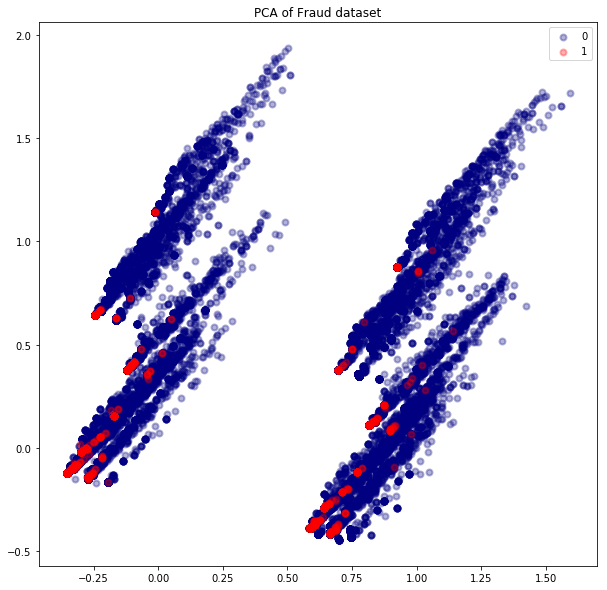

In [84]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_sc = scaler.fit_transform(X)
target_names = [0,1]
pca = PCA(n_components=2)
X_r = pca.fit(X_sc).transform(X_sc)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'% str(pca.explained_variance_ratio_))

plt.figure(figsize=(10,10))
colors = ['navy', 'red']
lw = 2
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.3, lw=lw,label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Fraud dataset')

plt.show()

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure(figsize=(10,10))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

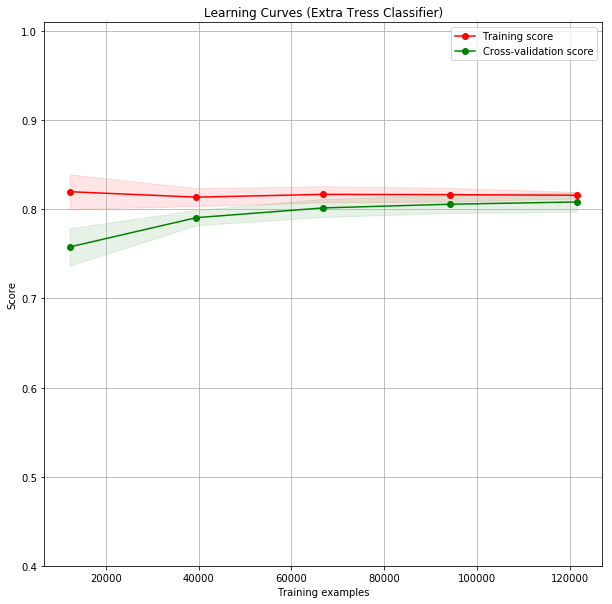

In [86]:
title = "Learning Curves (Extra Tress Classifier)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10,test_size=0.3,random_state=0)
estimator = BalancedBaggingClassifier(random_state=0,n_estimators=100,base_estimator=ExtraTreesClassifier(class_weight='balanced'))
plot_learning_curve(estimator,title,X,y,ylim=(0.4,1.01),cv=cv,n_jobs=4)
plt.show()

## Appendix - Unfinished Ideas below

In [87]:
# from sklearn.metrics import average_precision_score
# average_precision = average_precision_score(y_test, predictions)
# print('Average precision-recall score: {0:0.2f}'.format(average_precision))
# from sklearn.metrics import precision_recall_curve
# import matplotlib.pyplot as plt

# precision, recall, _ = precision_recall_curve(y_test,predictions)

# plt.step(recall, precision, color='b', alpha=0.2,where='post')
# plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.
#           format(average_precision))


In [88]:
# model = ExtraTreesClassifier(class_weight='balanced')
# model.fit(X_train_res, y_train_res)
# predictions_train = model.predict_proba(X_train_res)[:,1]
# print("Train ROC-AUC :",roc_auc_score(y_train_res, predictions_train))
# #print("Train Classification Report : \n",classification_report(y_train_res,predictions_train))
# predictions = model.predict_proba(X_test)[:,1]
# print("Test ROC-AUC :",roc_auc_score(y_test, predictions))
# plt.hist(predictions,log=True)
# #print("Train Classification Report : \n",classification_report(y_test, predictions))
# #print("Test Confusion Matrix :\n ")
# # cnf_matrix = confusion_matrix(y_test,predictions)
# # plt.figure()
# # plot_confusion_matrix(cnf_matrix, classes=[0,1],title='Confusion matrix, without normalization')
# plt.show()

In [89]:
# plt.hist(predictions,log=True)
# print(np.median(predictions))
# print(np.mean(predictions))
# print(np.percentile(predictions,q=25))
# print(np.percentile(predictions,q=50))
# print(np.percentile(predictions,q=75))
# #print("Train Classification Report : \n",classification_report(y_test, predictions))
# #print("Test Confusion Matrix :\n ")
# # cnf_matrix = confusion_matrix(y_test,predictions)
# # plt.figure()
# # plot_confusion_matrix(cnf_matrix, classes=[0,1],title='Confusion matrix, without normalization')
# plt.show()

Automatically created module for IPython interactive environment


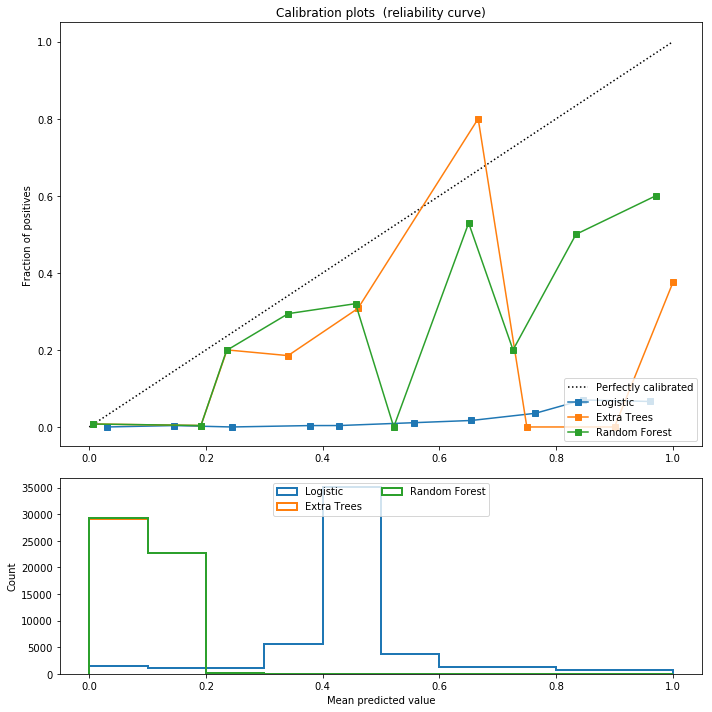

In [90]:
print(__doc__)

# Author: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.

import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve

X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=2)

train_samples = 100  # Samples used for training the models

X_train = X_train_res
X_test = X_test
y_train = y_train_res
y_test = y_test

# Create classifiers
lr = LogisticRegression(class_weight='balanced')
gnb = ExtraTreesClassifier(class_weight='balanced')
rfc = RandomForestClassifier(n_estimators=100,class_weight='balanced')


# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),(gnb, 'Extra Trees'),(rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

In [91]:
from sklearn.metrics import roc_curve, auc
def findOptimalCutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold']) 

In [92]:
print (findOptimalCutoff(y_train_res,predictions_train))

[1]


In [93]:
# import numpy as np
# import matplotlib.pyplot as plt
# from itertools import cycle

# from sklearn import svm, datasets
# from sklearn.metrics import roc_curve, auc
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import label_binarize
# from sklearn.multiclass import OneVsRestClassifier
# from scipy import interp

# # Binarize the output
# y = label_binarize(y, classes=[0, 1])
# n_classes = y.shape[1]

# # Add noisy features to make the problem harder
# random_state = np.random.RandomState(0)
# n_samples, n_features = X.shape
# X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# # shuffle and split training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,random_state=0)

# # Learn to predict each class against the other
# classifier = ExtraTreesClassifier(class_weight='balanced')
# y_score = classifier.fit(X_train, y_train)

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# plt.figure()
# lw = 2
# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()